In [29]:
! python3 -m pip install -U tensorflow==2.0.0a0 > /dev/null

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Perceptron using SKLearn

Single layer perceptron is a linear classifier. I can't solve the XOR problem. Stacking multiple single layer Perceptrons can solve the XOR problem

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]
y = (iris.target == 0).astype(np.int) # 0 is setosa

perceptron_classifier = Perceptron()
perceptron_classifier.fit(X, y)
y_pred = perceptron_classifier.predict(X)

# How many predictions are correct?
print((y == y_pred).sum())
# How many datapoints are in the dataset
print(len(y))

150
150


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


# Multilayer Perceptron


MLPs became computatinally feasable with the introduction of the [backpropagatino](https://scholar.google.com/scholar?q=Learning+Internal+Representations+by+Error+Propagation+author%3Arumelhart) algorithm, which is still in use. Using backpropagation the gradients of the error with respect to each of the parameters of the MLP are calculated, and then gradienct descent can be applied to learn the parameters iteratively. See [this article](https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a) for a simple explanation of Gradient Descent, and Stochastic Gradient Descent.

## Regression

In general, when building MLPs for regression, we don't use activation functions in the output layer. The loss function to use during training is typically the **mean squared error**, but if you have a lot of outliers in the training set, you may prefer to use the **mean absolute error instead**. 

## Classification

For binary classification or multiple binary labels we use a single output neuron with Logistic activation function. For Multiclass classification (single prediction of mutually exclusive classes), we generally use softmax. In all cases cross entropy is used as the loss function.

# Implementing MLPs using Keras

Keras is a high-level Deep Learning API that allows you to easily build, train, evaluate, and execute all sorts of neural networks. Checkout [https://keras.io](https://keras.io) for more information. Let's start with an image classification example:

In [3]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.0.0-alpha0'

In [4]:
# This dataset contains greyscale images 28 x 28 of clothing items
fashion_mnist = keras.datasets.fashion_mnist
# Only train/test datasets
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

print("Full train dataset shape", X_train_full.shape)
print("Train dataset dtype", X_train_full.dtype)

# Lets split train_full into train and validation. Use 5000 samples for validation 
# and 55000 for training. We also scale pixel greyscale values to [0,1]
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Define the name of each of the possible target values
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Full train dataset shape (60000, 28, 28)
Train dataset dtype uint8


In [5]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

# Get a summary of the network
model.summary()
# Access an individual layer
input_layer = model.layers[1]
print(input_layer.name)

# Get layer parameters. For Dense layers this include weights and bias
w, b = input_layer.get_weights()
print(w, b)

# Now let's define the learning parameters
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=keras.optimizers.SGD(learning_rate=0.001),
             metrics=["accuracy"])

# And train
history = model.fit(X_train, y_train, batch_size=50,
                    epochs=30, validation_data=(X_valid, y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________
dense
[[-0.03903364 -0.07402228 -0.00594018 ... -0.05199974  0.00261908
   0.0348765 ]
 [-0.06242717  0.06480186  0.06234729 ...  0.07346286  0.0386812
   0.04554992]
 [ 0.05093072  0.03205443 -0.06086833 ... -0.06708864  0.00808131
   0.02835153]


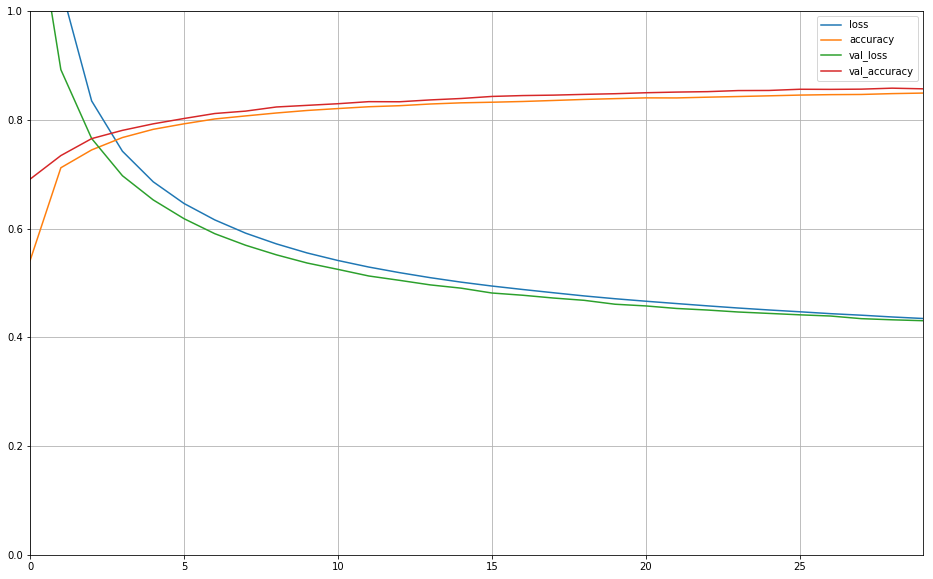

In [8]:
# Let's plot the history
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(16, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [16]:
# Let's see how the model perform on the test dataset
model.evaluate(X_test, y_test)

# We can finally use the model to obtain predictinos
y_proba = model.predict(X_test[:10])
print(y_proba.round(2))

# We can ask Keras to retrieve the highest probability class for us
y_pred = model.predict_classes(X_test[:10])
np.array(class_names)[y_pred]

10000/10000 [==============================] - 0s 44us/sample - loss: 70.7862 - accuracy: 0.8168
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sandal', 'Sneaker'], dtype='<U11')

Let's build a Regression example:

In [23]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

# Partition the full dataset into train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target)
# Partition the train dataset into train/validation
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full)

# Preprocess the training data using the StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# define the network
model = keras.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(optimizer="sgd", loss="mean_squared_error")
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_valid, y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 48us/sample - loss: 2.6178 - val_loss: 1.5728
Epoch 2/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.9073 - val_loss: 0.8027
Epoch 3/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.7275 - val_loss: 0.7108
Epoch 4/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.6761 - val_loss: 0.6608
Epoch 5/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.6419 - val_loss: 0.6286
Epoch 6/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.6127 - val_loss: 0.6020
Epoch 7/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5886 - val_loss: 0.5779
Epoch 8/20
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5669 - val_loss: 0.5593
Epoch 9/20
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5491 - val_l

In [28]:
# Let's evaluate the model on the test dataset, and perform som inference
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)
print(y_pred)
for i in range(3):
    print(y_pred[i] - y_test[i])

5160/5160 [==============================] - 0s 19us/sample - loss: 0.4412
[[1.8030876]
 [2.5339494]
 [1.5924091]]
[-0.02891243]
[0.46494937]
[-0.53959084]
